# Importing libraries

In [1]:
%matplotlib inline
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from sklearn.utils.class_weight import compute_class_weight

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF

print("Tensorflow version:", tf.__version__)

/tmp/ipykernel_14994/348416986.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2023-12-06 22:46:33.523878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 22:46:33.802546: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2023-12-06 22:46:33.802583: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do n

Tensorflow version: 2.11.0


# Data extracting

In [2]:
# !mv ../data/challenges_in_representation/train ../data/
# !mv ../data/challenges_in_representation/test ../data/

# Plot sample images

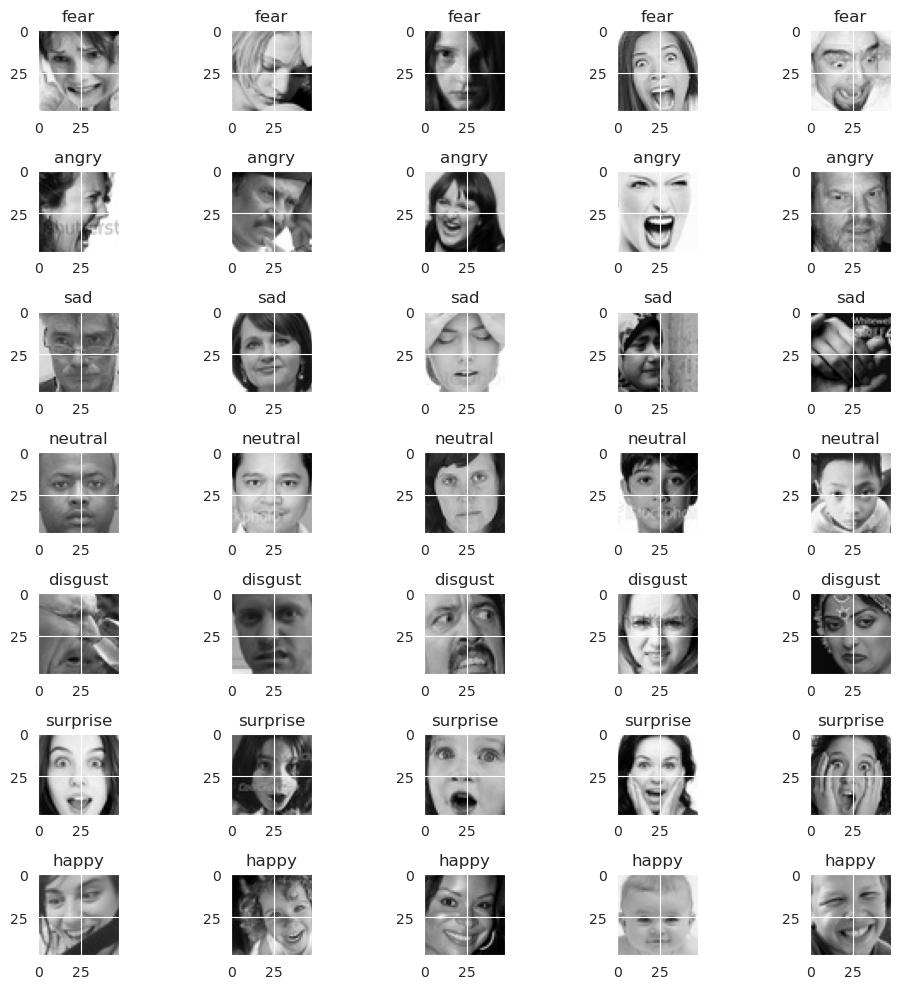

In [3]:
root_dir = "../data"

def plot_example_images():
    img_size = 48
    plt.figure(0, figsize=(10, 10))
    ctr = 0

    for expression in os.listdir(os.path.join(root_dir, "train")):
        class_name = expression
        
        for i, filename in enumerate(os.listdir(os.path.join(root_dir, "train", expression))[:5]):
            ctr += 1
            plt.subplot(7, 5, ctr)
            img = load_img(os.path.join(root_dir, "train", expression, filename), target_size=(img_size, img_size))
            plt.imshow(img, cmap='gray')
            plt.title(class_name)
    
    plt.tight_layout()
    plt.show()

plot_example_images()

# Data Distribution

In [4]:
def display_data_distribution(data_type):
    data_directory = os.path.join(root_dir, data_type)
    total_images = 0  # Initialize total images counter
    
    for expression in os.listdir(data_directory):
        expression_path = os.path.join(data_directory, expression)
        num_images = len(os.listdir(expression_path))
        total_images += num_images
        print(f"{num_images} {expression} images in {data_type} folder")
    
    print(f"Total images in {data_type.capitalize()} folder: {total_images}")  

In [5]:
display_data_distribution("train")

4097 fear images in train folder
3995 angry images in train folder
4830 sad images in train folder
4965 neutral images in train folder
436 disgust images in train folder
3171 surprise images in train folder
7214 happy images in train folder
Total images in Train folder: 28708


In [6]:
display_data_distribution("test")

1024 fear images in test folder
958 angry images in test folder
1247 sad images in test folder
1233 neutral images in test folder
111 disgust images in test folder
831 surprise images in test folder
1774 happy images in test folder
Total images in Test folder: 7178


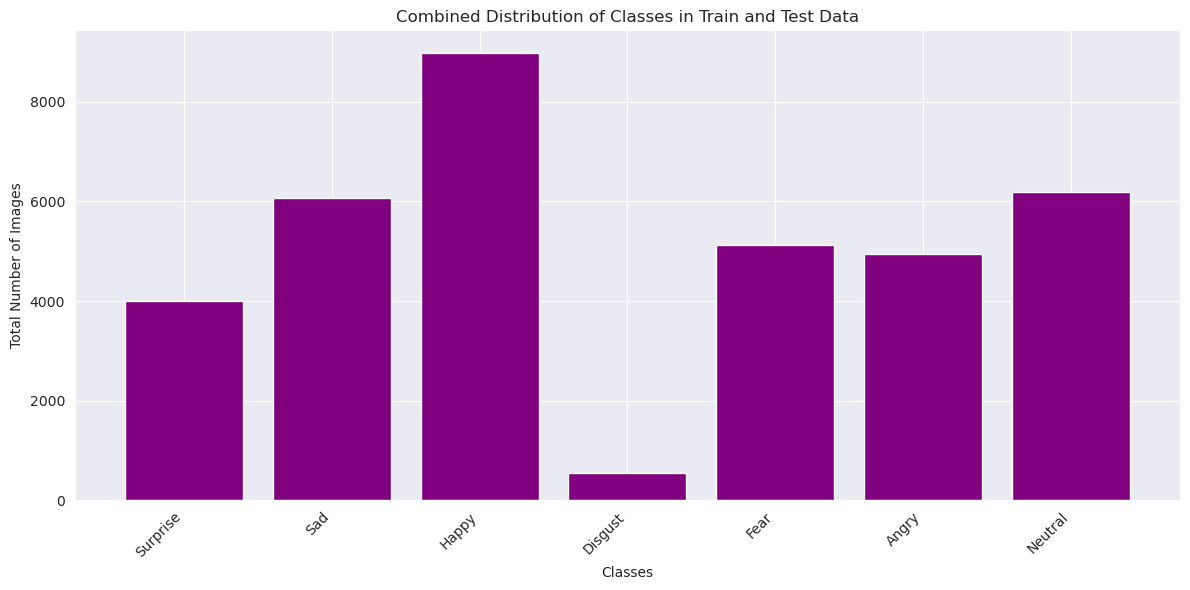

In [7]:
def plot_combined_data_distribution():
    train_directory = os.path.join(root_dir, "train")
    test_directory = os.path.join(root_dir, "test")
    train_dist = {}
    test_dist = {}

    # Calculate number of images for each class in the train directory
    for expression in os.listdir(train_directory):
        expression_path = os.path.join(train_directory, expression)
        num_images = len(os.listdir(expression_path))
        train_dist[expression.capitalize()] = num_images

    # Calculate number of images for each class in the test directory
    for expression in os.listdir(test_directory):
        expression_path = os.path.join(test_directory, expression)
        num_images = len(os.listdir(expression_path))
        test_dist[expression.capitalize()] = num_images

    # Summing the total number of images for each class across train and test directories
    combined_dist = {key: train_dist.get(key, 0) + test_dist.get(key, 0) for key in set(train_dist) | set(test_dist)}

    classes = list(combined_dist.keys())
    values = list(combined_dist.values())

    plt.figure(figsize=(12, 6))
    plt.bar(classes, values, color='purple')
    plt.title("Combined Distribution of Classes in Train and Test Data")
    plt.xlabel("Classes")
    plt.ylabel("Total Number of Images")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


plot_combined_data_distribution()

# Training and validation batch

In [8]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory(
    os.path.join(root_dir, "train"),
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

datagen_validation = ImageDataGenerator(horizontal_flip=True)

validation_generator = datagen_validation.flow_from_directory(
    os.path.join(root_dir, "test"),
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Create CNN Model

In [9]:
# Initialising the CNN
model_name = "NeuroVisionNet"
model = Sequential(name=model_name)

# 1 - Convolution
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(7, activation='softmax'))

# Compiling the model
opt = Adam(learning_rate=0.000001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

2023-12-06 22:47:10.578899: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-12-06 22:47:10.578983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: calcul-info-uqam-ca
2023-12-06 22:47:10.578995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: calcul-info-uqam-ca
2023-12-06 22:47:10.579132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 530.30.2
2023-12-06 22:47:10.579189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 530.30.2
2023-12-06 22:47:10.579198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 530.30.2
2023-12-06 22:47:10.579877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimize

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

# Training and evaluation function

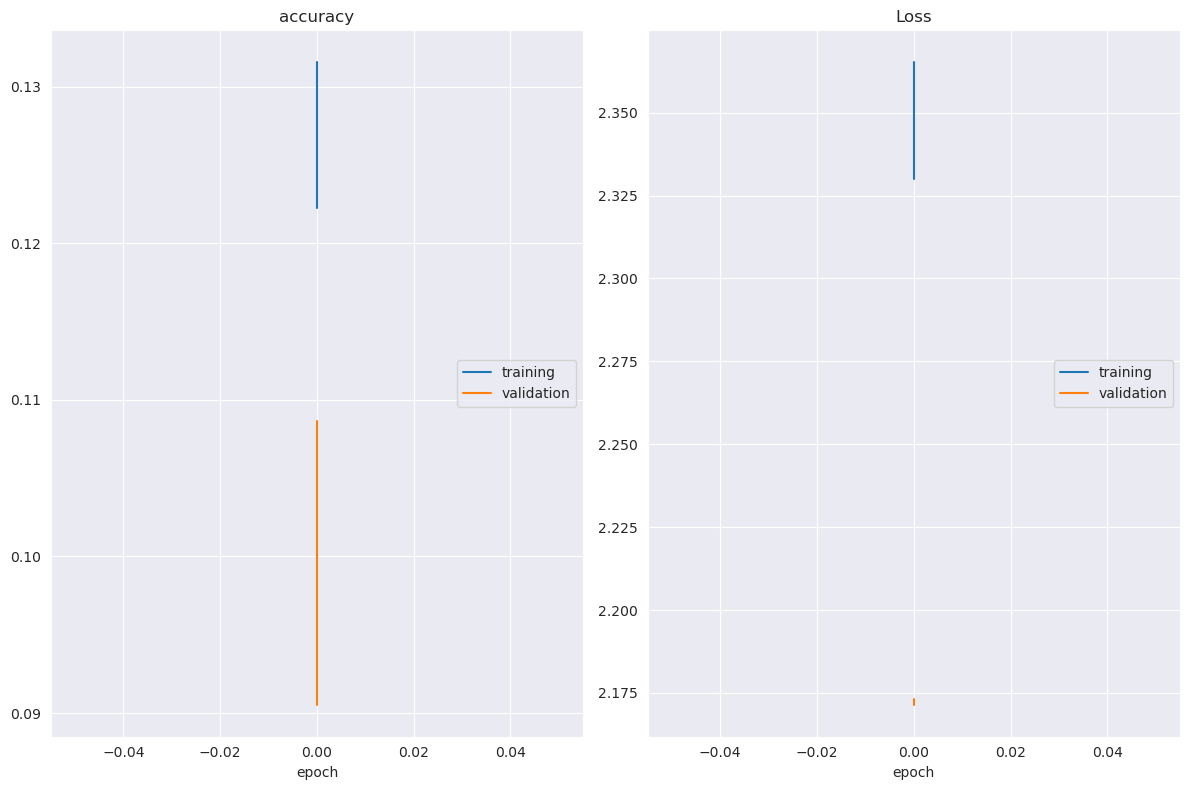

accuracy
	training         	 (min:    0.122, max:    0.132, cur:    0.132)
	validation       	 (min:    0.091, max:    0.109, cur:    0.091)
Loss
	training         	 (min:    2.330, max:    2.365, cur:    2.330)
	validation       	 (min:    2.171, max:    2.173, cur:    2.171)

Epoch 1: saving model to ../models/model_weights.h5
448/448 [==============================] - 192s 429ms/step - loss: 2.3300 - accuracy: 0.1315 - val_loss: 2.1715 - val_accuracy: 0.0905 - lr: 1.0000e-06
CPU times: user 2h 11min 22s, sys: 5min 12s, total: 2h 16min 34s
Wall time: 6min 25s


In [11]:
%%time

# Set up epochs and steps per epoch
epochs = 2
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

# Calculate class weights using compute_class_weight
class_weights = compute_class_weight(class_weight = 'balanced', 
                                     classes = np.unique(train_generator.classes), 
                                     y = train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

# Set up callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("../models/model_weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = {}

# Training loop with class weights for each epoch
for epoch in tqdm(range(epochs), desc="Epoch"):
    model.fit(
        x=train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=1,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        class_weight=class_weights_dict,
        callbacks=callbacks
    )

# Store model as JSON

In [13]:
model_json = model.to_json(indent=4)
with open(f"../models/{model_name}.json", "w") as json_file:
    json_file.write(model_json)